In [2]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import graph_statistics
import utils
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot, make_comparison_df, comparison_tabular_from_df)

# NetGAN vs our method

### Statistics used

In [3]:
statistic_fns = {'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 #'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 'Power Law α':graph_statistics.power_law_alpha,
                 #'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 #'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count
                 }

### Datasets (original graphs)

In [4]:
_A_obs = load_npz('../data/CORA_ML.npz')

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)
train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))

### Make dataframe and heatmap

In [5]:
df = make_comparison_df(datasets=['CORA-ML'], models={'baseline_NetGan':1, 'Ours':-1}, 
                        statistic_fns=statistic_fns,
                        overlap=0.5,
                        original_graphs={'CORA-ML':train_graph})

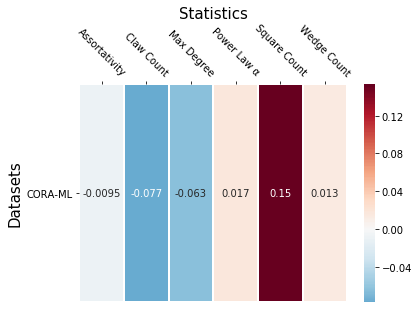

In [6]:
comparison_tabular_from_df(df, annot_size=10)

# For comparison: NetGAN vs Adjacency baseline

Maybe its best to compare with configuration model, because this baseline hits some statistics perfectly by definition (-> red), but fails at others worse than NetGAN (-> blue)

In [7]:
df = make_comparison_df(datasets=['CORA-ML'], models={'baseline_NetGan':1, 'baseline_FA':-1}, 
                        statistic_fns=statistic_fns,
                        overlap=0.5,
                        original_graphs={'CORA-ML':train_graph})

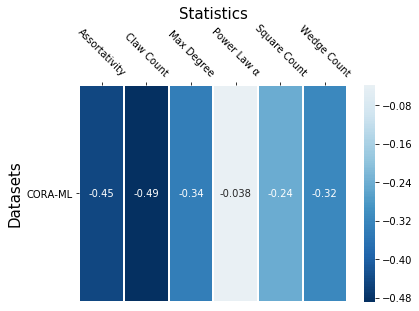

In [8]:
comparison_tabular_from_df(df, annot_size=10)